In [1]:
import torch
import matplotlib.pyplot as plt
from common import *
import time
import copy
import gym

import xarray as xr
import numpy as np

import os
import matplotlib

import pybullet_envs

def do_rollout_push(env, model, magnitude, rate, num_steps=1000, render=False):
    torch.autograd.set_grad_enabled(False)
    act_list = []
    obs_list = []
    rew_list = []
    x_list = []


    dtype = torch.float32
    obs = env.reset()
    done = False

    for cur_step in range(num_steps):
        if np.random.uniform() < rate:
            force = np.random.randn(2)
            force = (force / np.linalg.norm(force))*magnitude
            env.unwrapped.sim.data.xfrc_applied[1,:] = np.array([force[0],0,force[1],0,0,0])
            
        if render:
            env.render()
            time.sleep(.01)
        
        obs_list.append(obs)
        
        x_list.append(env.unwrapped.sim.data.qpos[0])


        act,_,_ = model(obs)
        obs, rew, done, _ = env.step(act)
        
        act_list.append((act))
        rew_list.append(rew)


    ep_length = len(rew_list)
    ep_obs = np.stack(obs_list)
    ep_act = np.stack(act_list)
    ep_rew = np.tensor(rew_list, dtype=dtype)
    ep_rew = ep_rew.reshape(-1, 1)

    torch.autograd.set_grad_enabled(True)
    return ep_obs, ep_act, ep_rew, x_list


def do_rollout_noise(env, model, obs_std=.001, act_std=.01, num_steps=1000, render=False):
    act_list = []
    obs_list = []
    rew_list = []
    done_list = []

    dtype = np.float32
    obs = env.reset()
    done = False
    obs_size = env.observation_space.shape[0]
    act_size = env.action_space.shape[0]

    for cur_step in range(num_steps):
        
        if render:
            env.render()
            time.sleep(.01)
        
        obs += np.random.randn(obs_size)*obs_std
        obs_list.append(np.copy(obs))
        
        #x_list.append(env.unwrapped.sim.data.qpos[0])

        act,_,_,_ = model.step(obs)
        act += np.random.randn(act_size)*act_std
        obs, rew, done, _ = env.step(act)
        
        act_list.append(torch.as_tensor(np.copy(act)))
        rew_list.append(rew)
        
        done_list.append(done)


    ep_length = len(rew_list)
    ep_obs = np.stack(obs_list)
    ep_act = np.stack(act_list)
    ep_rew = np.array(rew_list, dtype=dtype)
    ep_rew = ep_rew.reshape(-1, 1)

    return ep_obs, ep_act, ep_rew, done_list

# Variation dimensions

findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.
findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.
findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.


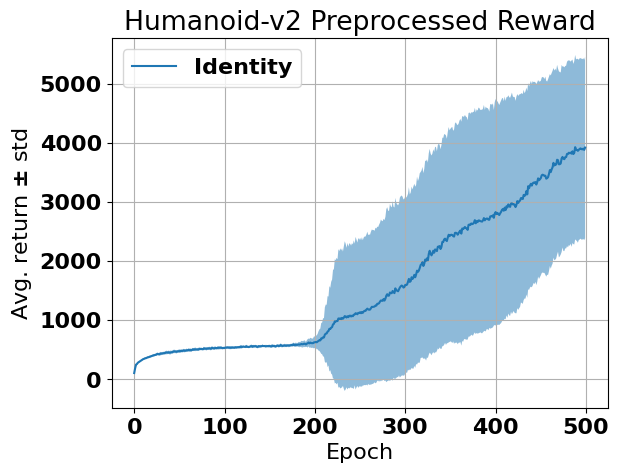

<Figure size 640x480 with 0 Axes>

In [2]:
matplotlib.style.use('default')

font = {'family' : 'normal',
        'weight' : 'bold',
        'size'   : 16}

matplotlib.rc('font', **font)

save_dir = "./data_hm0/"

#env_names = ['HalfCheetah-v2', 'Hopper-v2', 'Walker2d-v2']#, 'Ant-v2','Humanoid-v2']
env_names = ['Humanoid-v2']



for env_name in env_names:
    data = torch.load(f"{save_dir}{env_name}/data.xr")
    data = data.where(data.post!='radodiv', drop=True)

    model_dict = data.model_dict
    rews = data.rews#/data.post_rews
    exp_names = [fn.__name__ for fn in data.attrs['post_fns']]
    num_seeds = len(model_dict[exp_names[0]])

    means = rews.mean(dim="trial")
    stds = rews.std(dim="trial")

    #plt.subplots(1,1, figsize=(10,7))
    plt.plot(means.T)
    plt.legend(['Identity', 'Variogram','Madogram'], loc='upper left')
    ci = stds

    for mean, c in zip(means, ci):
        plt.fill_between([t for t in range(len(mean))], (mean-c), (mean+c), alpha=.5)
    plt.title(f"{env_name} Preprocessed Reward")
    plt.ylabel(r"Avg. return $\pm$ std")
    plt.xlabel(r"Epoch")
    plt.grid()
    plt.figure()

#     for exp_name in exp_names:  
#         plt.plot(rews.loc[exp_name].T[:,0:10])
#         plt.title(exp_name)
#         plt.figure()
#     top_seeds = {'identity':[0,1], 'cdim_div':[0,1]}

In [3]:
for env_name in env_names:
    env = gym.make(env_name)
    data = torch.load(f"{save_dir}{env_name}/data.xr")
    model_dict = data.model_dict
    init_d = 1e-6
    num_runs = 5; num_seeds=10
    post_fns = [identity]
    ep_length= 1000


    mshdims = xr.DataArray(np.zeros((len(post_fns), num_seeds, num_runs)),
                    dims = ("post", "seed", "run"),
                    coords = {"post": [fn.__name__ for fn in post_fns]})

    cdims =  xr.DataArray(np.zeros((len(post_fns), num_seeds, num_runs)),
                    dims = ("post", "seed", "run"),
                    coords = {"post": [fn.__name__ for fn in post_fns]})

    vdims = xr.DataArray(np.zeros((len(post_fns), num_seeds, num_runs)),
                    dims = ("post", "seed", "run"),
                    coords = {"post": [fn.__name__ for fn in post_fns]})

    mdims = xr.DataArray(np.zeros((len(post_fns), num_seeds, num_runs)),
                    dims = ("post", "seed", "run"),
                    coords = {"post": [fn.__name__ for fn in post_fns]})

    rdims =  xr.DataArray(np.zeros((len(post_fns), num_seeds, num_runs)),
                    dims = ("post", "seed", "run"),
                    coords = {"post": [fn.__name__ for fn in post_fns]})

    rews =  xr.DataArray(np.zeros((len(post_fns), num_seeds, num_runs)),
                    dims = ("post", "seed", "run"),
                    coords = {"post": [fn.__name__ for fn in post_fns]})

    for post_fn in post_fns:
        for i in range(num_seeds):
            for j in range(num_runs):
                model = model_dict[post_fn.__name__][i]
                o,a,r,l = do_rollout_noise(env, model,0,0, num_steps=ep_length)
                target = o[200:]
                target = (target - model.state_mean)/(model.state_std)
                #target = (target - target.mean(dim=0))/(target.std(dim=0))


                rews.loc[post_fn.__name__,i,j] = sum(r).item()

                mshdims.loc[post_fn.__name__,i,j], cdims.loc[post_fn.__name__,i,j] , _, _ = mesh_dim(target)
                mdims.loc[post_fn.__name__,i,j] = variation_dim(target)
                vdims.loc[post_fn.__name__,i,j] = variation_dim(target,order=2)
                rdims.loc[post_fn.__name__,i,j] = variation_dim(target,order=.5)
                

    print(f"{env_name}:")           
    print("madogram dimension")
    for fn in post_fns:
        mean = mdims.mean(dim=('seed','run')).loc[fn.__name__].item()
        std = mdims.std(dim=('seed','run')).loc[fn.__name__].item()
        print(f"{fn.__name__} mean: {mean}, std: {std}")

    print()
    print("variogram dimension")
    for fn in post_fns:
        mean = vdims.mean(dim=('seed','run')).loc[fn.__name__].item()
        std = vdims.std(dim=('seed','run')).loc[fn.__name__].item()
        print(f"{fn.__name__} mean: {mean}, std: {std}")

#     print()
#     print("rodogram dimension")
#     for fn in post_fns:
#         mean = rdims.mean(dim=('seed','run')).loc[fn.__name__].item()
#         std = rdims.std(dim=('seed','run')).loc[fn.__name__].item()
#         print(f"{fn.__name__} mean: {mean}, std: {std}")

    print()
    print("mesh dimension")
    for fn in post_fns:
        mean = mshdims.mean(dim=('seed','run')).loc[fn.__name__].item()
        std = mshdims.std(dim=('seed','run')).loc[fn.__name__].item()
        print(f"{fn.__name__} mean: {mean}, std: {std}")

    print()
    print("cmesh dimension")
    for fn in post_fns:
        mean = cdims.mean(dim=('seed', 'run')).loc[fn.__name__].item()
        std = cdims.std(dim=('seed', 'run')).loc[fn.__name__].item()
        print(f"{fn.__name__} mean: {mean}, std: {std}")

    print()
    print("rewards")
    for fn in post_fns:
        mean = rews.mean(dim=('seed', 'run')).loc[fn.__name__].item()
        std = rews.std(dim=('seed', 'run')).loc[fn.__name__].item()
        print(f"{fn.__name__} mean: {mean}, std: {std}")

    print(); print()

running build_ext


KeyboardInterrupt: 

# Mesh dimensions

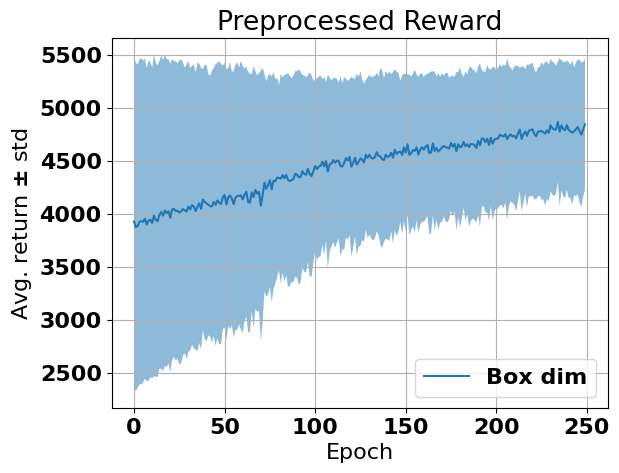

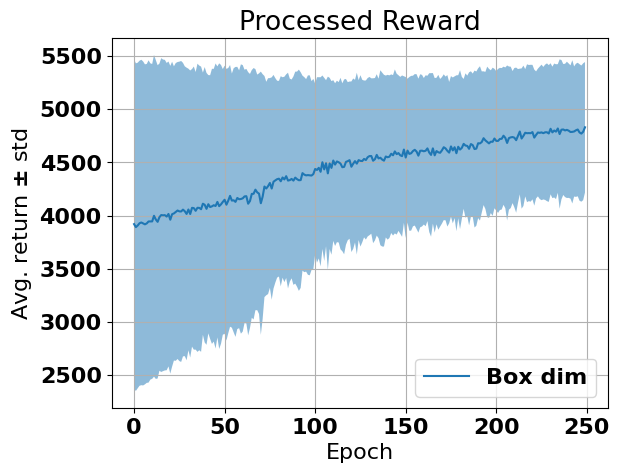

<Figure size 640x480 with 0 Axes>

In [4]:
#env_names = ["HalfCheetah-v2", "Hopper-v2", "Walker2d-v2"]#, "Ant-v2"]

env_names = ['Humanoid-v2']
mdim_save_dir = './data_hm0_mdim_long/'

matplotlib.style.use('default')

font = {'family' : 'normal',
        'weight' : 'bold',
        'size'   : 16}

matplotlib.rc('font', **font)
#init_names = ["identity", "madodiv", "identity", "identity"]
init_names = ["identity"]
for env_name, init_name in zip(env_names, init_names):
    init_data = torch.load(f"{save_dir}{env_name}/data.xr")
    init_model_dict = init_data.model_dict
    
    data = torch.load(f"{mdim_save_dir}{env_name}/data.xr")
    model_dict = data.model_dict
    model_dict['identity'] = init_model_dict['identity']
    rews = data.rews#/data.post_rews
    exp_names = [fn.__name__ for fn in data.attrs['post_fns']]
    num_seeds = len(model_dict[exp_names[0]])

    means = rews.mean(dim="trial")
    stds = rews.std(dim="trial")

    #plt.subplots(1,1, figsize=(10,7))
    plt.plot(means.T)
    plt.legend(['Box dim'], loc='lower right')
    ci = stds

    for mean, c in zip(means, ci):
        plt.fill_between([t for t in range(len(mean))], (mean-c), (mean+c), alpha=.5)
        
    plt.title(f"Preprocessed Reward")
    plt.ylabel(r"Avg. return $\pm$ std")
    plt.xlabel(r"Epoch")
    plt.grid()
    plt.figure()
    
    
    rews = data.post_rews
    exp_names = [fn.__name__ for fn in data.attrs['post_fns']]
    num_seeds = len(model_dict[exp_names[0]])

    means = rews.mean(dim="trial")
    stds = rews.std(dim="trial")

    #plt.subplots(1,1, figsize=(10,7))
    plt.plot(means.T)
    plt.legend(['Box dim'], loc='lower right')
    ci = stds

    for mean, c in zip(means, ci):
        plt.fill_between([t for t in range(len(mean))], (mean-c), (mean+c), alpha=.5)
        
    plt.title(f"Processed Reward")
    plt.ylabel(r"Avg. return $\pm$ std")
    plt.xlabel(r"Epoch")
    plt.grid()
    plt.figure()

  

[4650.735]
True
1.3970902038996602 2.1285338740543653
False
[6245.0923]
5.185023982716285 5.570843027344011


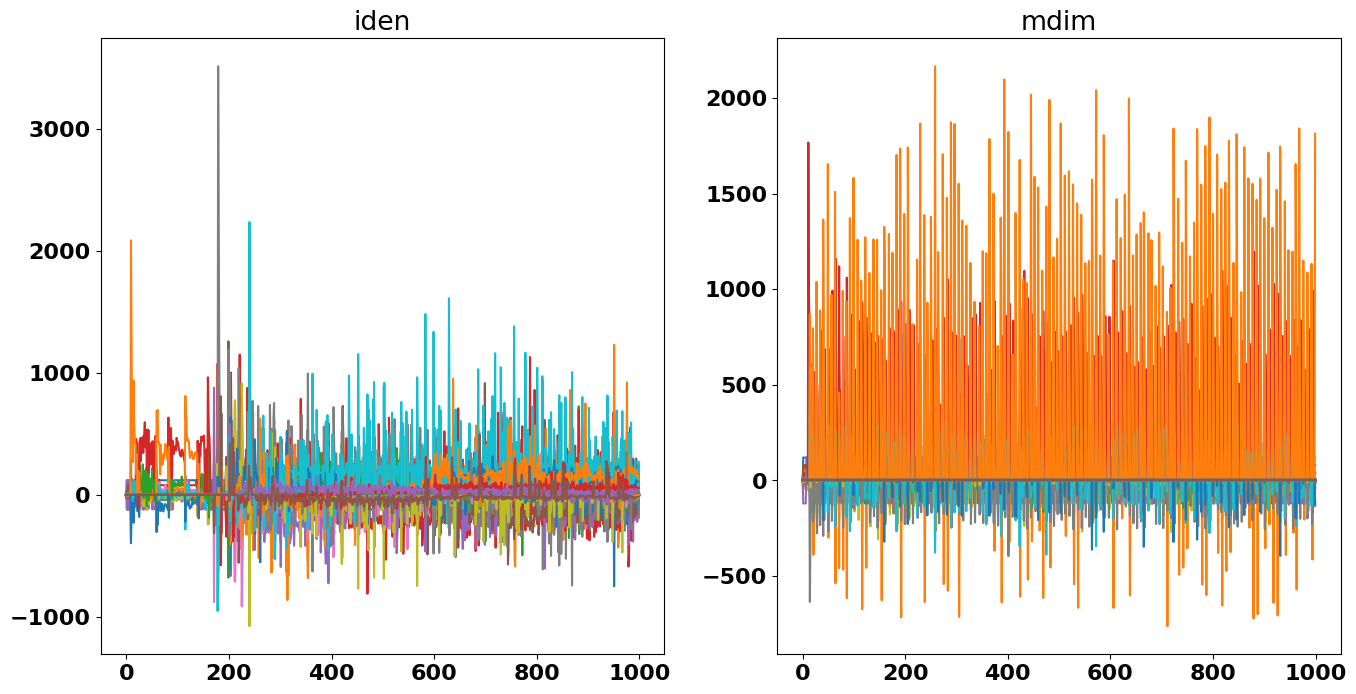

In [5]:
seed = 5

model = model_dict['mdim_div'][seed]
init_model = init_model_dict['identity'][seed]

plt.figure(figsize=(16,8))



o,a,r,d = do_rollout_noise(env, init_model, act_std=0, obs_std=0, num_steps=1000)
print(sum(r))
print(any(d[:-1]))
plt.subplot(121)
plt.title("iden")
plt.plot(o);

target = o[200:]
target = (target - init_model.state_mean)/(init_model.state_std)
#target = (target - target.mean(dim=0))/target.std(dim=0)

mdim, cdim , _, _ = mesh_dim(target, init_d=1e-6)
print(mdim, cdim)

o,a,r,d = do_rollout_noise(env, model, act_std=0, obs_std=0, num_steps=1000)
print(any(d[:-1]))
print(sum(r))

plt.subplot(122)
plt.plot(o);
plt.title("mdim")

target = o[200:]
target = (target - model.state_mean)/(model.state_std)
#target = (target - target.mean(dim=0))/target.std(dim=0)

mdim, cdim , _, done_list = mesh_dim(target, init_d=1e-6)
print(mdim, cdim)




In [12]:
# env_names = ["HalfCheetah-v2", "Hopper-v2", "Walker2d-v2"]#, "Ant-v2"]
# init_names = ["identity", "madodiv", "identity"]#, "identity"]

#env_names = ["Ant-v2"]
#init_names = ["identity"]

env_names = ['Humanoid-v2']
init_names = ["identity"]

post_names= ['init', 'mdim_div']
post_fns = [mdim_div]


init_d = 1e-6
num_runs = 5; num_seeds=10
ep_length= 1000


#post_names= ['init', 'mdim_div', 'cdim_div']
#post_fns = [mdim_div, cdim_div]


for env_name, init_name in zip(env_names, init_names):
    env = gym.make(env_name)
    #init_data = torch.load(f"./data_noise1/{env_name}.xr")
    init_data = torch.load(f"{save_dir}{env_name}/data.xr")

    init_model_dict = init_data.model_dict
    
    #data = torch.load(f"./data_noise1_mdim/{env_name}.xr")
    data = torch.load(f"./{mdim_save_dir}{env_name}/data.xr")

    model_dict = data.model_dict
        
    mshdims = xr.DataArray(np.zeros((len(post_fns)+1, num_seeds, num_runs)),
                    dims = ("post", "seed", "run"),
                    coords = {"post": post_names})

    cdims =  xr.DataArray(np.zeros((len(post_fns)+1, num_seeds, num_runs)),
                    dims = ("post", "seed", "run"),
                    coords = {"post": post_names})

    vdims = xr.DataArray(np.zeros((len(post_fns)+1, num_seeds, num_runs)),
                    dims = ("post", "seed", "run"),
                    coords = {"post": post_names})

    mdims = xr.DataArray(np.zeros((len(post_fns)+1, num_seeds, num_runs)),
                    dims = ("post", "seed", "run"),
                    coords = {"post": post_names})

    rdims =  xr.DataArray(np.zeros((len(post_fns)+1, num_seeds, num_runs)),
                    dims = ("post", "seed", "run"),
                    coords = {"post": post_names})

    rews =  xr.DataArray(np.zeros((len(post_fns)+1, num_seeds, num_runs)),
                    dims = ("post", "seed", "run"),
                    coords = {"post": post_names})
    
    dones =  xr.DataArray(np.zeros((len(post_fns)+1, num_seeds, num_runs)),
                    dims = ("post", "seed", "run"),
                    coords = {"post": post_names})
    

    
    for post_fn in post_fns:
        for i in range(num_seeds):
            for j in range(num_runs):
                model = model_dict[post_fn.__name__][i]
                o,a,r,d = do_rollout_noise(env, model, act_std=0, obs_std=0, num_steps=ep_length)
                target = o[200:]
                #target = (target - target.mean(dim=0))/target.std(dim=0)

                target = (target - model.state_mean)/(model.state_std)
             
                rews.loc[post_fn.__name__,i,j] = sum(r).item()

                mshdims.loc[post_fn.__name__,i,j], cdims.loc[post_fn.__name__,i,j] , _, _ = mesh_dim(target, init_d=1e-6)
                mdims.loc[post_fn.__name__,i,j] = variation_dim(target)
                vdims.loc[post_fn.__name__,i,j] = variation_dim(target,order=2)
                rdims.loc[post_fn.__name__,i,j] = variation_dim(target,order=.5)
                dones.loc[post_fn.__name__,i,j] = any(d[:-1])
                
    
    for i in range(num_seeds):
        for j in range(num_runs):
            model = init_model_dict[init_name][i]
            o,a,r,d = do_rollout_noise(env, model, act_std=0, obs_std=0, num_steps=ep_length)

            #o,a,r,l = do_long_rollout(env, model, ep_length=ep_length)
            target = o[200:]
            target = (target - model.state_mean)/(model.state_std)
            #target = (target - target.mean(dim=0))/target.std(dim=0)


            rews.loc[post_names[0],i,j] = sum(r).item()

            mshdims.loc[post_names[0],i,j], cdims.loc[post_names[0],i,j] , _, _ = mesh_dim(target, init_d=1e-6)
            mdims.loc[post_names[0],i,j] = variation_dim(target)
            vdims.loc[post_names[0],i,j] = variation_dim(target,order=2)
            rdims.loc[post_names[0],i,j] = variation_dim(target,order=.5)
            dones.loc[post_names[0],i,j] = any(d[:-1])


            
            
    
    print(f"{env_name}:")           
    print("madogram dimension")
    for name in post_names:
        mean = mdims.mean(dim=('seed','run')).loc[name].item()
        std = mdims.std(dim=('seed','run')).loc[name].item()
        print(f"{name} mean: {mean}, std: {std}")

    print()
    print("variogram dimension")
    for name in post_names:
        mean = vdims.mean(dim=('seed','run')).loc[name].item()
        std = vdims.std(dim=('seed','run')).loc[name].item()
        print(f"{name} mean: {mean}, std: {std}")

#     print()
#     print("rodogram dimension")
#     for name in post_names:
#         mean = rdims.mean(dim=('seed','run')).loc[name].item()
#         std = rdims.std(dim=('seed','run')).loc[name].item()
#         print(f"{name} mean: {mean}, std: {std}")

    print()
    print("mesh dimension")
    for name in post_names:
        mean = mshdims.mean(dim=('seed','run')).loc[name].item()
        std = mshdims.std(dim=('seed','run')).loc[name].item()
        print(f"{name} mean: {mean}, std: {std}")

    print()
    print("cmesh dimension")
    for name in post_names:
        mean = cdims.mean(dim=('seed', 'run')).loc[name].item()
        std = cdims.std(dim=('seed', 'run')).loc[name].item()
        print(f"{name} mean: {mean}, std: {std}")

    print()
    print("rewards")
    for name in post_names:
        mean = rews.mean(dim=('seed', 'run')).loc[name].item()
        std = rews.std(dim=('seed', 'run')).loc[name].item()
        print(f"{name} mean: {mean}, std: {std}")

    print(); print()

Humanoid-v2:
madogram dimension
init mean: 2.0155131045516934, std: 0.9018510459139106
mdim_div mean: 1.6610754223868267, std: 0.4117716721443076

variogram dimension
init mean: 2.0077565522758465, std: 0.45092552295695537
mdim_div mean: 1.830537711193413, std: 0.20588583607215383

mesh dimension
init mean: 3.7480432362661844, std: 1.48795961855596
mdim_div mean: 4.393267312549953, std: 0.6990202344957767

cmesh dimension
init mean: 5.027838737365112, std: 1.697013563801576
mdim_div mean: 5.724484309348782, std: 0.745551029625635

rewards
init mean: 4915.037705078125, std: 425.1557531370792
mdim_div mean: 5099.118388671875, std: 509.4082640533594




In [13]:
mshdims.where(dones==0).mean(dim=('run', 'seed'))

<xarray.DataArray (post: 2)>
array([4.39826818, 4.39326731])
Coordinates:
  * post     (post) <U8 'init' 'mdim_div'

In [8]:
cdims.where(dones!=1).mean(dim=('run', 'seed'))

<xarray.DataArray (post: 2)>
array([5.85676836, 5.68393275])
Coordinates:
  * post     (post) <U8 'init' 'mdim_div'

In [11]:
dones.mean(dim=('run'))

<xarray.DataArray (post: 2, seed: 10)>
array([[1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
       [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.]])
Coordinates:
  * post     (post) <U8 'init' 'mdim_div'
Dimensions without coordinates: seed

In [ ]:
env_names = ["Walker2d-v2"]
init_names = ["identity"]

init_d = 1e-6
num_runs = 5; num_seeds=10
ep_length= 1000

post_names= ['cdim_div', 'mdim_div']
post_fns = [cdim_div, mdim_div]

walking_seeds = {'cdim_div': [0,1,3,4,5,8], 'mdim_div':[0,1,3,4,5,6,8,9]}

for env_name, init_name in zip(env_names, init_names):
    env = gym.make(env_name)
    init_data = torch.load(f"./data17/{env_name}.xr")
    init_model_dict = init_data.policy_dict
    
    data = torch.load(f"./data_mcshdim4/{env_name}.xr")
    policy_dict = data.policy_dict
    policy_dict['identity'] = init_policy_dict['identity']
        
    mshdims = xr.DataArray(np.zeros((len(post_fns), num_seeds, num_runs)),
                    dims = ("post", "seed", "run"),
                    coords = {"post": post_names})

    cdims =  xr.DataArray(np.zeros((len(post_fns), num_seeds, num_runs)),
                    dims = ("post", "seed", "run"),
                    coords = {"post": post_names})

    vdims = xr.DataArray(np.zeros((len(post_fns), num_seeds, num_runs)),
                    dims = ("post", "seed", "run"),
                    coords = {"post": post_names})

    mdims = xr.DataArray(np.zeros((len(post_fns), num_seeds, num_runs)),
                    dims = ("post", "seed", "run"),
                    coords = {"post": post_names})

    rdims =  xr.DataArray(np.zeros((len(post_fns), num_seeds, num_runs)),
                    dims = ("post", "seed", "run"),
                    coords = {"post": post_names})

    rews =  xr.DataArray(np.zeros((len(post_fns), num_seeds, num_runs)),
                    dims = ("post", "seed", "run"),
                    coords = {"post": post_names})

    
    for post_fn in post_fns:
        for i in walking_seeds[post_fn.__name__]:
            for j in range(num_runs):
                policy = policy_dict[post_fn.__name__][i]
                o,a,r,l = do_rollout_noise(env, policy, act_std=0.01, obs_std=0.001, num_steps=ep_length)

                #o,a,r,l = do_long_rollout(env, policy, ep_length=ep_length)
                target = o[200:]
                target = (target - policy.state_means)/(policy.state_std)
             
                rews.loc[post_fn.__name__,i,j] = sum(r).item()

                mshdims.loc[post_fn.__name__,i,j], cdims.loc[post_fn.__name__,i,j] , _, _ = mesh_dim(target, init_d=1e-6)
                #mdims.loc[post_fn.__name__,i,j] = variation_dim(target)
                #vdims.loc[post_fn.__name__,i,j] = variation_dim(target,order=2)
                #rdims.loc[post_fn.__name__,i,j] = variation_dim(target,order=.5)
                
    

    print(f"{env_name}:")           
    print("madogram dimension")
    for name in post_names:
        mean = mdims.isel(seed=walking_seeds[name]).loc[name].mean(dim=('seed','run')).item()
        std = mdims.isel(seed=walking_seeds[name]).loc[name].std(dim=('seed','run')).item()
        print(f"{name} mean: {mean}, std: {std}")

    print()
    print("variogram dimension")
    for name in post_names:
        mean = vdims.isel(seed=walking_seeds[name]).loc[name].mean(dim=('seed','run')).item()
        std = vdims.isel(seed=walking_seeds[name]).loc[name].std(dim=('seed','run')).item()
        print(f"{name} mean: {mean}, std: {std}")

#     print()
#     print("rodogram dimension")
#     for name in post_names:
#         mean = rdims.isel(seed=walking_seeds[name]).loc[name].mean(dim=('seed','run')).item()
#         std = rdims.isel(seed=walking_seeds[name]).loc[name].std(dim=('seed','run')).item()
#         print(f"{name} mean: {mean}, std: {std}")

    print()
    print("mesh dimension")
    for name in post_names:
        mean = mshdims.isel(seed=walking_seeds[name]).loc[name].mean(dim=('seed','run')).item()
        std = mshdims.isel(seed=walking_seeds[name]).loc[name].std(dim=('seed','run')).item()
        print(f"{name} mean: {mean}, std: {std}")

    print()
    print("cmesh dimension")
    for name in post_names:
        mean = cdims.isel(seed=walking_seeds[name]).loc[name].mean(dim=('seed','run')).item()
        std = cdims.isel(seed=walking_seeds[name]).loc[name].std(dim=('seed','run')).item()
        print(f"{name} mean: {mean}, std: {std}")

    print()
    print("rewards")
    for name in post_names:
        mean = rews.isel(seed=walking_seeds[name]).loc[name].mean(dim=('seed','run')).item()
        std = rews.isel(seed=walking_seeds[name]).loc[name].std(dim=('seed','run')).item()
        print(f"{name} mean: {mean}, std: {std}")

    print(); print()

CPU times: user 1.25 s, sys: 0 ns, total: 1.25 s
Wall time: 1.25 s
tensor([5850.3643])
2.5328911076764062
7.003631060455803


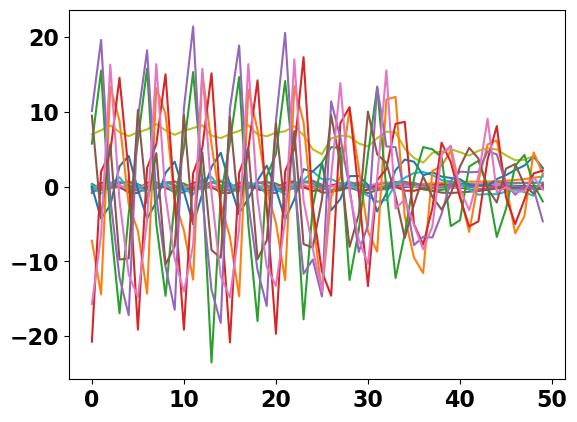

<Figure size 640x480 with 0 Axes>

In [36]:
env_name = "HalfCheetah-v2"
init_data = torch.load(f"./data17/{env_name}.xr")
init_policy_dict = init_data.policy_dict

data = torch.load(f"./data_mcshdim4/{env_name}.xr")
policy_dict = data.policy_dict
policy_dict['identity'] = init_policy_dict['identity']
seed = 2
ep_length = 10000
policy = policy_dict['identity'][seed]
env = gym.make(env_name)
%time o,a,r,_ = do_long_rollout(env, policy, ep_length= ep_length)
#o,a,r,l = do_rollout(env, policy, render=True)

plt.plot(o[1000:1050])
plt.figure()

target = o[200:]
target = (target - policy.state_means)/policy.state_std
#target = (target - policy.state_means)/policy.state_std
 
print(sum(r))
m,c,l,d = mesh_dim(target, init_d=1e-9, d_limit=1e-13)
print(m)
print(c)

CPU times: user 1.29 s, sys: 0 ns, total: 1.29 s
Wall time: 1.29 s
tensor([44152.2148])
0.3591096477485378
1.3135214470918797


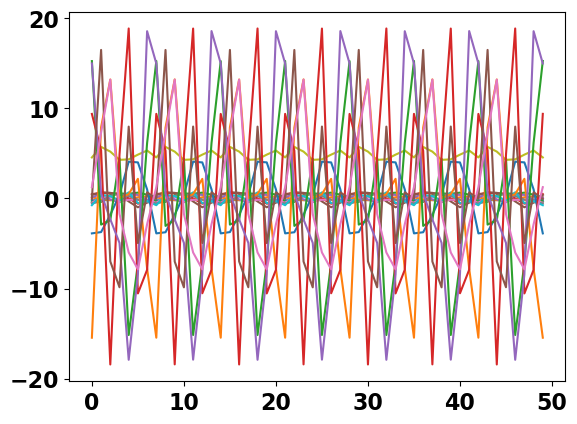

<Figure size 640x480 with 0 Axes>

In [53]:
seed = 2
ep_length = 10000
policy = policy_dict['mdim_div'][seed]
env = gym.make(env_name)
%time o2,a2,r2,_ = do_long_rollout(env, policy, ep_length= ep_length)

plt.plot(o2[1000:1050])
plt.figure()

target2 = o2[200:]
target2 = (target2 - policy.state_means)/policy.state_std
#target = (target - policy.state_means)/policy.state_std
 
print(sum(r2))
m2,c2,l2,d2 = mesh_dim(target2, init_d=1e-9, d_limit=1e-13)
print(m2)
print(c2)

In [38]:
seed = 2
ep_length = 10000
policy = policy_dict['cdim_div'][seed]
env = gym.make(env_name)
%time o3,a3,r3,_ = do_long_rollout(env, policy, ep_length= ep_length)

plt.plot(o3[1000:1050])
plt.figure()

target3 = o3[200:]
target3 = (target3 - policy.state_means)/policy.state_std
#target = (target - policy.state_means)/policy.state_std
 
print(sum(r3))
m3,c3,l3,d3 = mesh_dim(target3, init_d=1e-9, d_limit=1e-13)
print(m3)
print(c3)

KeyError: 'cdim_div'

<Figure size 640x480 with 0 Axes>

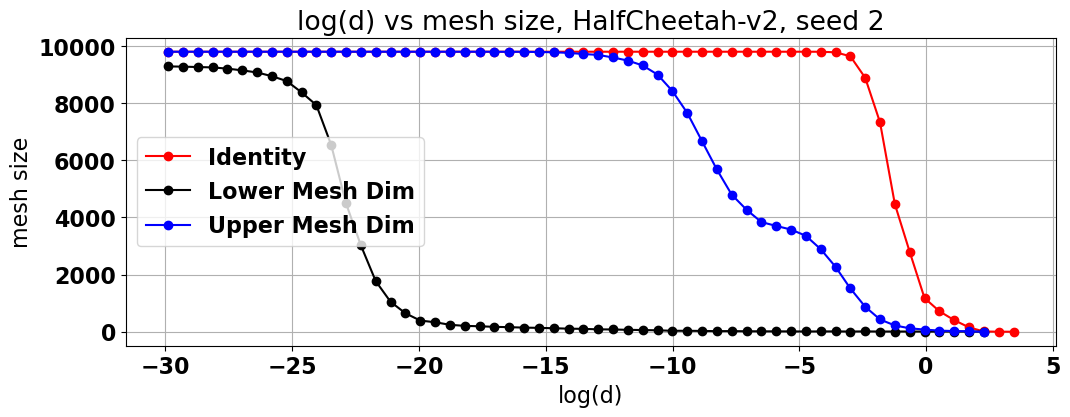

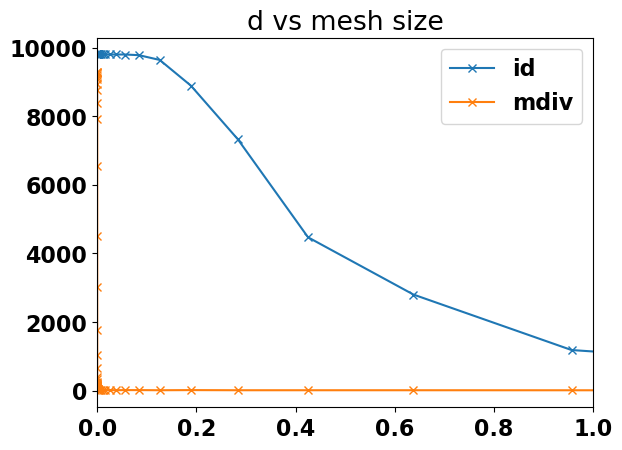

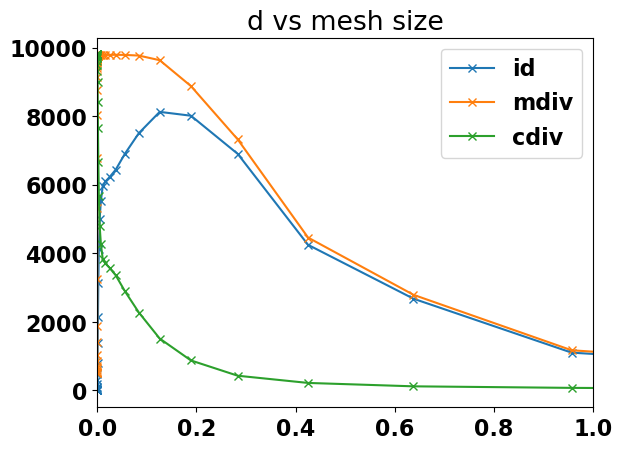

<Figure size 640x480 with 0 Axes>

In [39]:
# plt.plot(np.log2(d2), np.array(l[:-1]) - np.array(l2),'x-')
# plt.title('log2(d) vs cdiv mesh size')
# plt.figure()

plt.figure(figsize=(12,4))
plt.plot(np.log2(d), l,'o-', color='r')
plt.plot(np.log2(d2), l2,'o-' ,color='k')
plt.plot(np.log2(d3), l3,'o-',color='b' )

plt.legend(['Identity', 'Lower Mesh Dim','Upper Mesh Dim'])
plt.title("log(d) vs mesh size, HalfCheetah-v2, seed 2")
plt.xlabel("log(d)")
plt.ylabel("mesh size")
plt.grid()



plt.figure()

plt.plot(d, l,'x-')
plt.plot(d2, l2,'x-')
plt.legend(['id', 'mdiv'])
plt.title("d vs mesh size")
plt.xlim([0,1])
plt.figure()

plt.plot(d[:-2], np.array(l[:-2]) - np.array(l3),'x-')
plt.plot(d[:-2], np.array(l[:-2]) - np.array(l2),'x-')
plt.xlim([0,1])

plt.plot(d3, l3,'x-')
plt.legend(['id', 'mdiv', 'cdiv'])
plt.title("d vs mesh size")
plt.xlim([0,1])
plt.figure()

In [ ]:
import time
for seed in range(num_seeds):
    fail=0
    for i in range(10):
        obs, acts, rews, _ = do_long_rollout(env, init_policy_dict['identity'][seed], ep_length=10000)
        #plt.plot(obs)
        if sum(rews) < 0:

        
            fail+=1
            
    print(seed,fail)

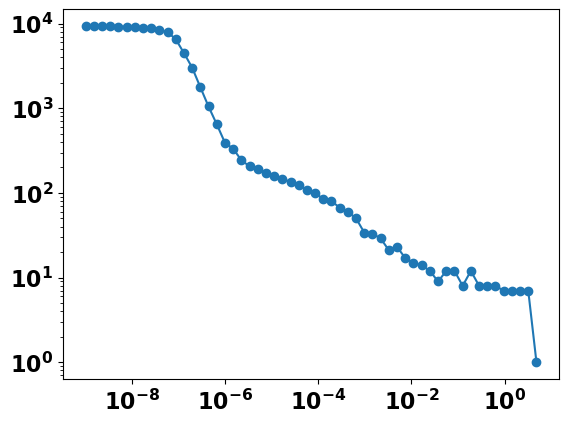

In [43]:
plt.loglog(d2,l2,'o-')